In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time

In [2]:
import astropy.units as u
import astropy.cosmology.units as cu
import astropy.constants as const

In [3]:
import raytrace

In [11]:
group_id = str(12925051)

In [52]:
with h5py.File("outputs/dm_proto.hdf5", "r") as f:
    print(f[group_id].keys())
    cm = np.array(f[group_id]['GroupCM'], dtype=np.float64)
    r500 = np.float64(f[group_id]['Group_R_Crit500'])

<KeysViewHDF5 ['DM', 'Direction', 'GroupCM', 'GroupMassType', 'GroupSFR', 'Group_R_Crit500', 'Impact', 'RayID']>


In [53]:
with h5py.File(f'tng_cache/cutout_{group_id}.hdf5', 'r') as f:
    m_g = np.array(f['PartType0/Masses'], dtype=np.float64) * (1e10 * u.solMass).to(u.kg) / cu.littleh
    rho_g = np.array(f['PartType0/Density'], dtype=np.float64) * (1e10 * u.solMass).to(u.kg) / cu.littleh / ( u.kpc / cu.littleh)**3
    V = m_g/rho_g
    r = ((0.75/np.pi)*V)**(1/3)
    eta_e = np.array(f['PartType0/ElectronAbundance'])
    X_H = np.array(f['PartType0/GFM_Metals'][:,0])
    pos = np.array(f['PartType0/Coordinates'][:]) - cm
    n_e = rho_g * eta_e * X_H / const.m_p

In [54]:
pos.size

3000243

In [55]:
samples = 100

In [56]:
indices = np.arange(samples, dtype=np.int64)
impact = np.zeros((samples, 3), dtype=np.float64)
direction = np.zeros((samples, 3), dtype=np.float64)
dispersion = np.zeros(samples, dtype=np.float64)
dispersion_sphere = np.zeros(samples, dtype=np.float64)

In [57]:
for i in indices:
    t = time.time()
    b = r500 * np.random.rand(3) # impact parameter
    n = np.random.rand(3) # direction
    n /= np.sqrt(raytrace.norm2(n))
    intersects, lengths = raytrace.voronoi_intersect(pos, 5*r.value, b, n, log=False)
    dm = np.sum(lengths * n_e.value[intersects])

    impact[i] = b
    direction[i] = n
    dispersion[i] = dm
    print(i, time.time() - t)


0 10.927269697189331
1 6.892537593841553
2 10.052313327789307
3 11.27648401260376
4 10.941614389419556
5 10.544550657272339
6 8.616355895996094
7 13.51764440536499
8 8.921249866485596
9 8.866366624832153
10 11.120454549789429
11 6.533103704452515
12 9.313929557800293
13 9.957059383392334
14 10.799168586730957
15 8.865808725357056
16 9.463632345199585
17 11.068733930587769
18 14.191058158874512
19 10.42029881477356
20 8.51607894897461
21 9.970994472503662
22 6.89188814163208
23 10.886707544326782
24 5.305797338485718
25 7.382194757461548
26 6.989895582199097
27 5.367709636688232
28 6.439190864562988
29 8.106074571609497
30 9.67448878288269
31 10.900270938873291
32 7.3640711307525635
33 12.955904245376587
34 9.395968437194824
35 6.8915698528289795
36 7.76146125793457
37 8.59039568901062
38 7.187318325042725
39 10.820821046829224
40 10.154799461364746
41 9.016128063201904
42 9.965073347091675
43 8.01919937133789
44 7.605506896972656
45 8.436409711837769
46 7.881881952285767
47 7.108608484

In [83]:
dispersion_sphere = np.zeros(samples, dtype=np.float64)
for i in indices:
    t = time.time()
    b = impact[i]
    n = direction[i]
    intersects, lengths = raytrace.sphere_intersect(pos, r.value, b, n, log=False)
    dm = np.sum(lengths * n_e.value[intersects])
    dispersion_sphere[i] = dm
    times.append(time.time() - t)
print('time:',np.mean(times))

time: 0.03574231266975403


In [81]:
with h5py.File("outputs/dm_proto.hdf5", "a") as f:
    print(f.keys())
    f[group_id]["RayID"] = indices
    f[group_id]["Impact"] = impact
    f[group_id]["Direction"] = direction
    f[group_id]["DM"] = dispersion
    f[group_id]["DMSphere"] = dispersion_sphere

<KeysViewHDF5 ['12925051']>


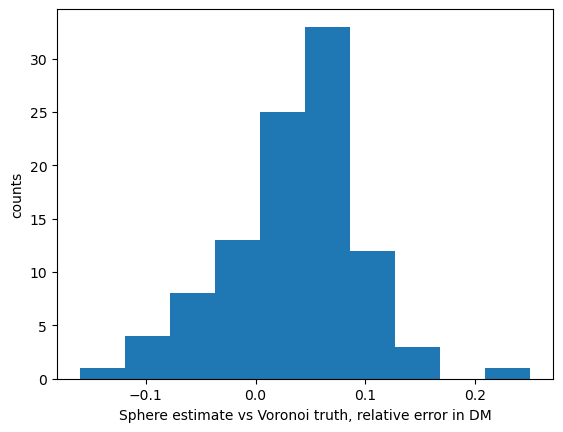

In [86]:
with h5py.File("outputs/dm_proto.hdf5", "r") as f:
    plt.hist(np.array(f[group_id]['DMSphere'])/np.array(f[group_id]['DM']) - 1)
    plt.xlabel('Sphere estimate vs Voronoi truth, relative error in DM')
    plt.ylabel('counts')

In [69]:
import importlib
importlib.reload(raytrace)

<module 'raytrace' from '/home/xingyzt/Documents/halo/raytrace.py'>